## Imports

In [364]:
# Imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

## Carga de datos

En el dataset, los datos no definidos (missing) estan especificados con un simbolo de interrogacion.

In [422]:
data = pd.read_csv('dataset/automobile.csv', na_values=['?'])
data.columns

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')

### Definimos que atributos son categoricos

Notese que especificamos como ordenados aquellos atributos que lo merecen, como son el numero de puertas y el numero de cilindros. Entre categorias, hay una relacion de tamano que puede ser util posteriormente.

In [431]:
data.symboling          = pd.Categorical(data.symboling)
data.make               = pd.Categorical(data.make)
data.fuel_type          = pd.Categorical(data.fuel_type)
data.aspiration         = pd.Categorical(data.aspiration)
data.body_style         = pd.Categorical(data.body_style)
data.drive_wheels       = pd.Categorical(data.drive_wheels)
data.engine_location    = pd.Categorical(data.engine_location)
data.engine_type        = pd.Categorical(data.engine_type)
data.fuel_system        = pd.Categorical(data.fuel_system)


# Cambiamos las categorias numericas por el numero correspondiente:
str_to_num = {"num_of_doors":     {"two": int(2), "four": 4},
              "num_of_cylinders": {"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12 }}

data.replace(str_to_num, inplace=True)

data.info()

NameError: name 'int64' is not defined

## Valores faltantes (Missing Values)

### Busqueda de Missings
Nuestro dataset ya especicaba los valores missing con un '?'. Podemos verlo en la informacion de nuestro dataframe:

In [424]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          205 non-null    category
 1   normalized_losses  164 non-null    float64 
 2   make               205 non-null    category
 3   fuel_type          205 non-null    category
 4   aspiration         205 non-null    category
 5   num_of_doors       203 non-null    float64 
 6   body_style         205 non-null    category
 7   drive_wheels       205 non-null    category
 8   engine_location    205 non-null    category
 9   wheel_base         205 non-null    float64 
 10  length             205 non-null    float64 
 11  width              205 non-null    float64 
 12  height             205 non-null    float64 
 13  curb_weight        205 non-null    int64   
 14  engine_type        205 non-null    category
 15  num_of_cylinders   205 non-null    int64   
 16  engine_s

A pesar de ello, creemos adecuado comprobar que no haya valores extranos, como podrian ser ceros donde no deberia, o numeros que puedan parecer un error de medicion como +-999999.

In [425]:
data.describe()

,normalized_losses,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,164.000000,203.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,122.000000,3.123153,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,35.442168,0.994841,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,65.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.000000,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,115.000000,4.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,150.000000,4.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,256.000000,4.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


Vemos que tanto los minimos como los maximos de todas las variables continuas no parecen ser errores, sino datos reales.

### Tratamiento de Missings

Dependiendo que atributo sea el que contiene missing values, y que cantidad haya de estos, actuaremos de una manera u otra:

#### 'Price'
Dado que el objetivo es hacer regresion sobre el atributo 'price', creemos conveniente eliminar las 4 filas que no contienen este atributo, ya que son pocas y creemos que no merece la pena imputar valores que luego vamos a intentar predecir, ya sea para fase de training o de test.

In [426]:
data = data[~data['price'].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          201 non-null    category
 1   normalized_losses  164 non-null    float64 
 2   make               201 non-null    category
 3   fuel_type          201 non-null    category
 4   aspiration         201 non-null    category
 5   num_of_doors       199 non-null    float64 
 6   body_style         201 non-null    category
 7   drive_wheels       201 non-null    category
 8   engine_location    201 non-null    category
 9   wheel_base         201 non-null    float64 
 10  length             201 non-null    float64 
 11  width              201 non-null    float64 
 12  height             201 non-null    float64 
 13  curb_weight        201 non-null    int64   
 14  engine_type        201 non-null    category
 15  num_of_cylinders   201 non-null    int64   
 16  engine_s

Nos hemos dado cuenta de que los unicos dos coches de la marca Renault, tienen missings, en 3 de sus columnas. Creemos que es adecuado eliminar estas 2 filas ya que desde nuestro punto de vista, les falta demasiada informacion y ambas conforman una marca completa. Es decir, imputar estas 3 columnas, influira directamente sobre cualquier prediccion de la marca Renault, y creemos que 2 filas son pocas y podemos tolerar eliminarlas.

In [427]:
print("Renault info: \n")
data[data['make'] == 'renault'].info()
data = data[data['make'] != 'renault']
print("\nDataset info after deleting Renault rows: \n")
data.info()

Renault info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 130 to 131
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          2 non-null      category
 1   normalized_losses  0 non-null      float64 
 2   make               2 non-null      category
 3   fuel_type          2 non-null      category
 4   aspiration         2 non-null      category
 5   num_of_doors       2 non-null      float64 
 6   body_style         2 non-null      category
 7   drive_wheels       2 non-null      category
 8   engine_location    2 non-null      category
 9   wheel_base         2 non-null      float64 
 10  length             2 non-null      float64 
 11  width              2 non-null      float64 
 12  height             2 non-null      float64 
 13  curb_weight        2 non-null      int64   
 14  engine_type        2 non-null      category
 15  num_of_cylinders   2 non-null      int64 

El dataset cuenta con unos coches con un motor muy peculiar de la marca Mazda. Este motor, conocido como motor Wankel es de tipo rotativo , es decir, genera energia cinetica de forma rotativa directamente sin hacer uso de pistones lineales. Esto es importanto porque, al no contar con pistones, no contamos con los datos 'bore' y 'stroke' (calibre y carrera), ya que son caracteristicas propias de los pistones. Eso explica los missing values en estos datos. 

In [428]:
data.info()
data[data['engine_type'] == 'rotor'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          199 non-null    category
 1   normalized_losses  164 non-null    float64 
 2   make               199 non-null    category
 3   fuel_type          199 non-null    category
 4   aspiration         199 non-null    category
 5   num_of_doors       197 non-null    float64 
 6   body_style         199 non-null    category
 7   drive_wheels       199 non-null    category
 8   engine_location    199 non-null    category
 9   wheel_base         199 non-null    float64 
 10  length             199 non-null    float64 
 11  width              199 non-null    float64 
 12  height             199 non-null    float64 
 13  curb_weight        199 non-null    int64   
 14  engine_type        199 non-null    category
 15  num_of_cylinders   199 non-null    int64   
 16  engine_s

Podemos ver que todos los missings de 'bore' y de 'stroke' son de los motores rotativos. Procedemos a ponerlos todos a 0 ya que consideramos que el recorrido y el calibre es nulo:

In [429]:
data['bore'].fillna(0, inplace=True)
data['stroke'].fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          199 non-null    category
 1   normalized_losses  164 non-null    float64 
 2   make               199 non-null    category
 3   fuel_type          199 non-null    category
 4   aspiration         199 non-null    category
 5   num_of_doors       197 non-null    float64 
 6   body_style         199 non-null    category
 7   drive_wheels       199 non-null    category
 8   engine_location    199 non-null    category
 9   wheel_base         199 non-null    float64 
 10  length             199 non-null    float64 
 11  width              199 non-null    float64 
 12  height             199 non-null    float64 
 13  curb_weight        199 non-null    int64   
 14  engine_type        199 non-null    category
 15  num_of_cylinders   199 non-null    int64   
 16  engine_s

Utilizamos KNN para imputar el valor de los missings que faltan del atributo "num_of_cylinders":

In [430]:
subset_of_data = data.drop(columns=['normalized_losses', 'num_of_doors'])
data_without_missings = subset_of_data[data.num_of_doors.notna() & data.normalized_losses.notna()]

data_num_of_doors_missing = subset_of_data[data.num_of_doors.isna()]
knn_cylinder = KNeighborsClassifier(n_neighbors=1)
knn_cylinder.fit(data_without_missings, data.num_of_doors[data.num_of_doors.notna() & data.normalized_losses.notna()])

ValueError: could not convert string to float: 'audi'

In [ ]:
print(knn_cylinder.predict(data_num_of_cylinders_missing))

In [ ]:
num_doors_missing = data[data['num_of_doors'].isnull()]

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(credit_without_missings, Credit.Capital[Credit.Income.notna()&
                             Credit.Capital.notna() & 
                             Credit.ChargesOnCapital.notna()])
knn_cap = knn.predict(capital_missing_values);

## Inspeccion de los diferentes atributos

### Atributos continuos

In [269]:
data.describe()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,164.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,122.000000,98.824121,174.151256,65.882412,53.775879,2556.030151,126.824121,3.262462,3.184975,10.178995,103.396985,5117.587940,25.201005,30.683417,13243.432161
std,35.442168,6.090838,12.371905,2.110996,2.447039,519.855544,41.752932,0.540233,0.553000,4.022424,37.553843,480.521824,6.451826,6.849410,7978.707609
min,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,0.000000,0.000000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.000000,94.500000,166.550000,64.100000,52.000000,2157.000000,97.500000,3.140000,3.090000,8.550000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,119.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10345.000000
75%,150.000000,102.400000,183.500000,66.700000,55.550000,2930.500000,143.000000,3.585000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16501.500000
max,256.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


### Atributos categoricos

0     64
1     52
2     31
3     27
-1    22
-2     3
Name: symboling, dtype: int64


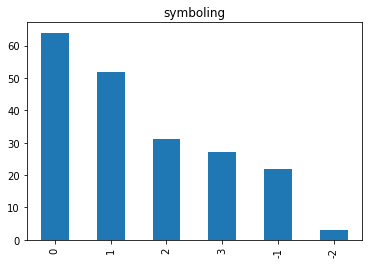

In [270]:
print(data['symboling'].value_counts())
data['symboling'].value_counts().plot(kind='bar', title='symboling');

gas       179
diesel     20
Name: fuel_type, dtype: int64


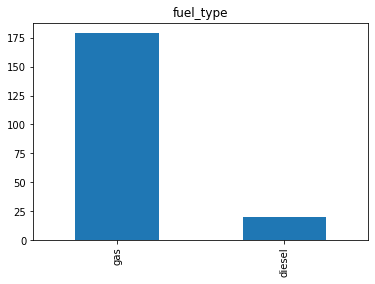

In [271]:
print(data['fuel_type'].value_counts())
data['fuel_type'].value_counts().plot(kind='bar', title='fuel_type');

std      163
turbo     36
Name: aspiration, dtype: int64


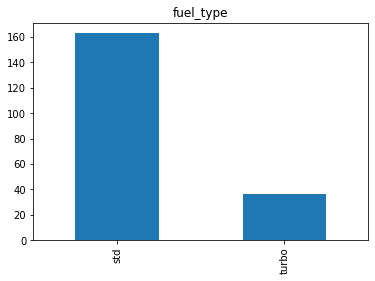

In [272]:
print(data['aspiration'].value_counts())
data['aspiration'].value_counts().plot(kind='bar', title='fuel_type');

four    112
two      85
Name: num_of_doors, dtype: int64


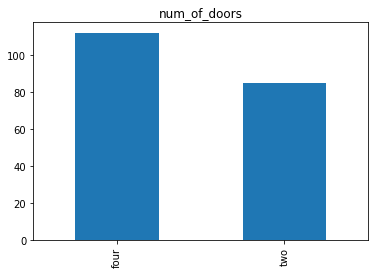

In [273]:
print(data['num_of_doors'].value_counts())
data['num_of_doors'].value_counts().plot(kind='bar', title='num_of_doors');

sedan          94
hatchback      67
wagon          24
hardtop         8
convertible     6
Name: body_style, dtype: int64


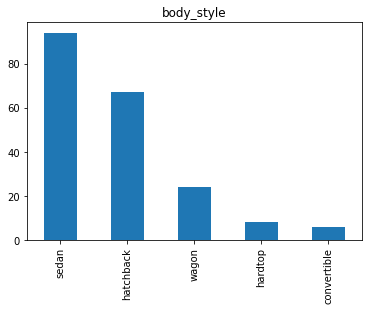

In [274]:
print(data['body_style'].value_counts())
data['body_style'].value_counts().plot(kind='bar', title='body_style');

fwd    116
rwd     75
4wd      8
Name: drive_wheels, dtype: int64


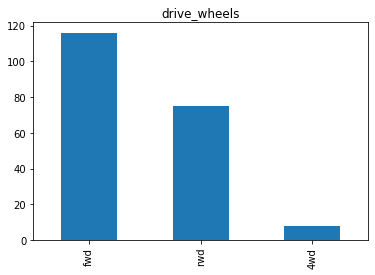

In [275]:
print(data['drive_wheels'].value_counts())
data['drive_wheels'].value_counts().plot(kind='bar', title='drive_wheels');

front    196
rear       3
Name: engine_location, dtype: int64


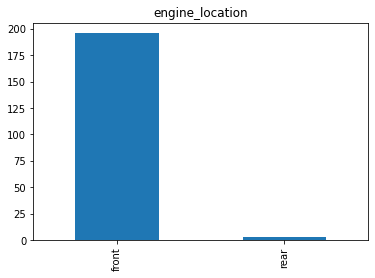

In [276]:
print(data['engine_location'].value_counts())
data['engine_location'].value_counts().plot(kind='bar', title='engine_location');

ohc      143
ohcf      15
ohcv      13
l         12
dohc      12
rotor      4
dohcv      0
Name: engine_type, dtype: int64


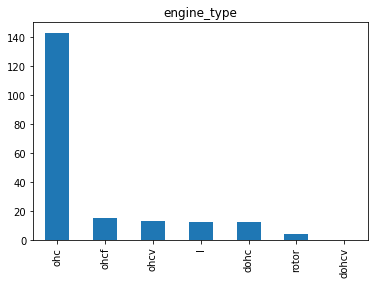

In [277]:
print(data['engine_type'].value_counts())
data['engine_type'].value_counts().plot(kind='bar', title='engine_type');

four     155
six       24
five      10
eight      4
two        4
Name: num_of_cylinders, dtype: int64


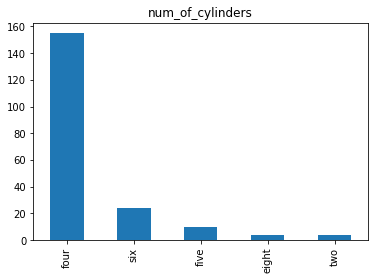

In [278]:
print(data['num_of_cylinders'].value_counts())
data['num_of_cylinders'].value_counts().plot(kind='bar', title='num_of_cylinders');

mpfi    90
2bbl    64
idi     20
1bbl    11
spdi     9
4bbl     3
spfi     1
mfi      1
Name: fuel_system, dtype: int64


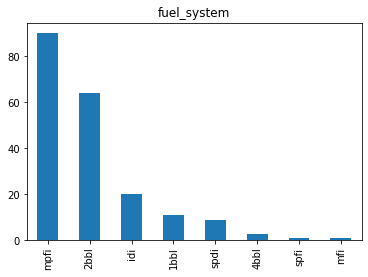

In [279]:
print(data['fuel_system'].value_counts())
data['fuel_system'].value_counts().plot(kind='bar', title='fuel_system');